<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2015. Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_pycon2015/).</i></small>

# Supervised Learning In-Depth: Random Forests

Previously we saw a powerful discriminative classifier, **Support Vector Machines**.
Here we'll take a look at motivating another powerful algorithm. This one is a *non-parametric* algorithm called **Random Forests**.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('TkAgg')
# TkAgg : Agg rendering to a Tk canvas (requires TkInter)

%matplotlib inline
import matplotlib.pyplot as plt

# set seaborn plot defaults.
# This can be safely commented out
import seaborn; seaborn.set()

import numpy as np

## Motivating Random Forests: Decision Trees

Random forests are an example of an *ensemble learner* built on decision trees.
For this reason we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification:

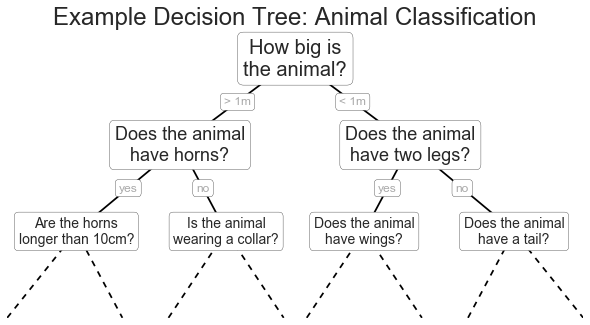

In [2]:
def plot_example_decision_tree():
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
    ax.set_title('Example Decision Tree: Animal Classification', size=24)
    
    def text(ax, x, y, t, size=20, **kwargs):
        ax.text(x, y, t,
                ha='center', va='center', size=size,
                bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)
        
    text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
    text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
    text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
    text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
    text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
    text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
    text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)
        
    text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
    text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

    text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
    text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

    text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
    text(ax, 0.79, 0.45, "no", 12, alpha=0.4)
    
    ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
    ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
    ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
    ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
    ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
    ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
    ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
    ax.axis([0, 1, 0, 1])
    
plot_example_decision_tree()

The binary splitting makes this extremely efficient.
As always, though, the trick is to *ask the right questions*.
This is where the algorithmic process comes in: in training a decision tree classifier, the algorithm looks at the features and decides which questions (or "splits") contain the most information.

### Creating a Decision Tree

Here's an example of a decision tree classifier in scikit-learn. We'll start by defining some two-dimensional labeled data:

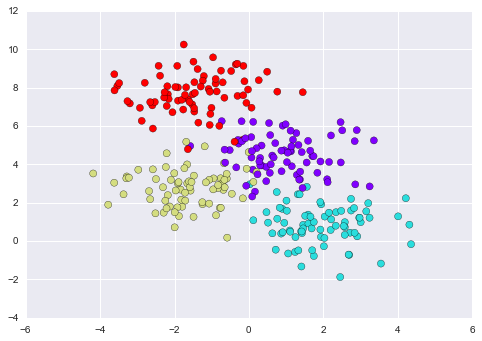

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

We have some convenience functions in the repository that help 

Now using IPython's ``interact`` (available in IPython 2.0+, and requires a live kernel) we can view the decision tree splits:

In [4]:
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact

def plot_tree_interactive(X, y):
    
    def interactive_tree(depth=1):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)
        
    interact(interactive_tree, depth=[1, 5])
    
def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None):
    estimator.fit(X, y)
    
    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=.2, cmap='rainbow')
    plt.clim(y.min(), y.max())
    
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
    plt.axis('off')
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(y.min(), y.max())
    
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = estimator.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

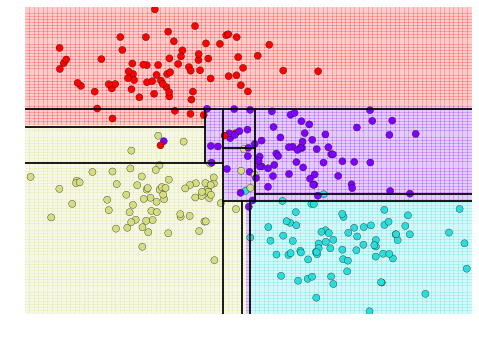

In [5]:
plot_tree_interactive(X, y)

Notice that at each increase in depth, every node is split in two **except** those nodes which contain only a single class.
The result is a very fast **non-parametric** classification, and can be extremely useful in practice.

**Question: Do you see any problems with this?**

### Decision Trees and over-fitting

One issue with decision trees is that it is very easy to create trees which **over-fit** the data. That is, they are flexible enough that they can learn the structure of the noise in the data rather than the signal! For example, take a look at two trees built on two subsets of this dataset:

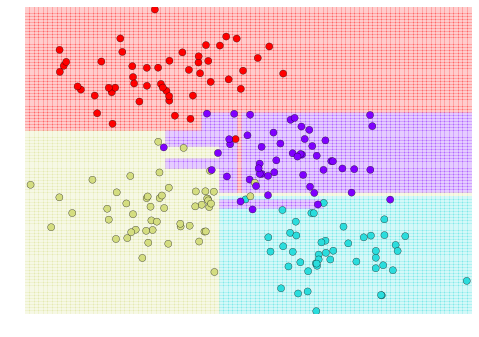

In [12]:
clf = DecisionTreeClassifier()

plt.figure()
visualize_tree(clf, X[:200], y[:200], boundaries=False);

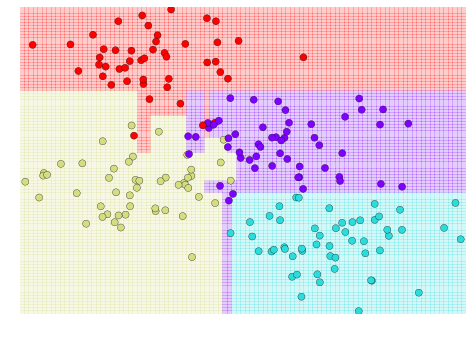

In [13]:
plt.figure()
visualize_tree(clf, X[-200:], y[-200:], boundaries=False);

The details of the classifications are completely different! That is an indication of **over-fitting**: when you predict the value for a new point, the result is more reflective of the noise in the model rather than the signal.

## Ensembles of Estimators: Random Forests

One possible way to address over-fitting is to use an **Ensemble Method**: this is a meta-estimator which essentially averages the results of many individual estimators which over-fit the data. Somewhat surprisingly, the resulting estimates are much more robust and accurate than the individual estimates which make them up!

One of the most common ensemble methods is the **Random Forest**, in which the ensemble is made up of many decision trees which are in some way perturbed.

There are volumes of theory and precedent about how to randomize these trees, but as an example, let's imagine an ensemble of estimators fit on subsets of the data. We can get an idea of what these might look like as follows:

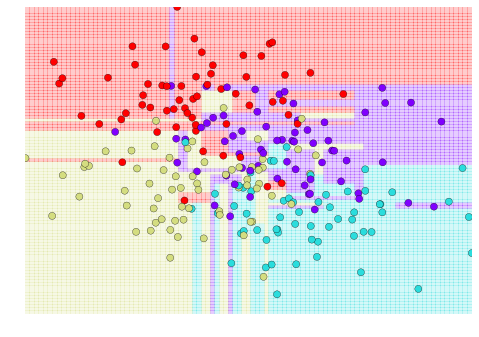

In [15]:
def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=2.0)
    clf = DecisionTreeClassifier(max_depth=15)
    
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))
    
interact(fit_randomized_tree, random_state = [0, 100]);

See how the details of the model change as a function of the sample, while the larger characteristics remain the same!
The random forest classifier will do something similar to this, but use a combined version of all these trees to arrive at a final answer:

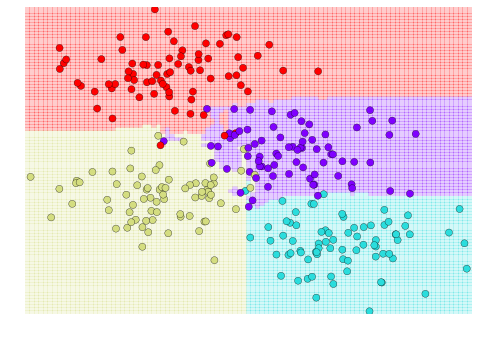

In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_tree(clf, X, y, boundaries=False)

By averaging over 100 randomly perturbed models, we end up with an overall model which is a much better fit to our data!

*(Note: above we randomized the model through sub-sampling... Random Forests use more sophisticated means of randomization, which you can read about in, e.g. the [scikit-learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest)*)

## Quick Example: Moving to Regression

Above we were considering random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is ``sklearn.ensemble.RandomForestRegressor``.

Let's quickly demonstrate how this can be used:

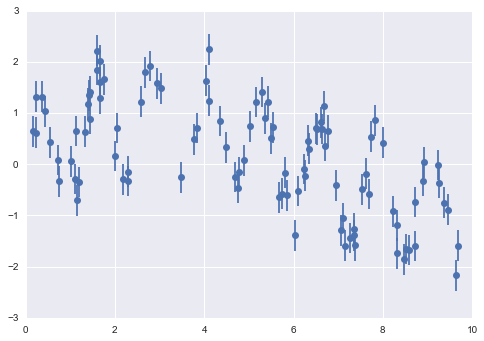

In [25]:
from sklearn.ensemble import RandomForestRegressor

x = 10 * np.random.rand(100)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * np.random.randn(len(x))
    
    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

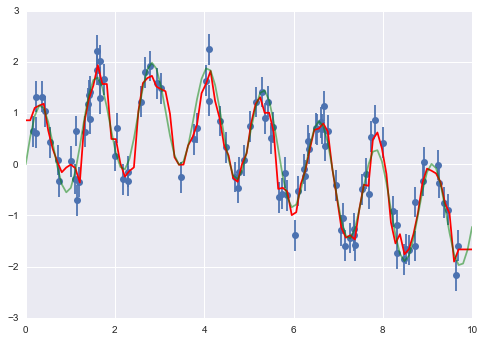

In [32]:
xfit = np.linspace(0, 10, 100)
yfit = RandomForestRegressor(100).fit(x[:, None], y).predict(xfit[:, None])
ytrue = model(xfit, 0)

plt.errorbar(x, y, 0.3, fmt='o')
plt.plot(xfit, yfit, '-r')
plt.plot(xfit, ytrue, '-g', alpha=.5);

As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us even specifying a multi-period model!

## Example: Random Forest for Classifying Digits

We previously saw the **hand-written digits** data. Let's use that here to test the efficacy of the SVM and Random Forest classifiers.

In [35]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['target_names', 'images', 'DESCR', 'data', 'target'])

In [36]:
X = digits.data
y = digits.target
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


To remind us what we're looking at, we'll visualize the first few data points:

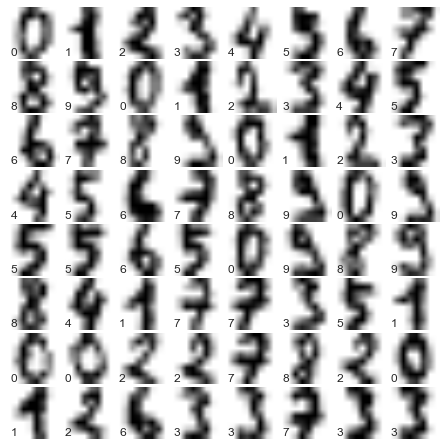

In [37]:
# set up the figure
fig = plt.figure(figsize=(6, 6)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, 
                    hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary)
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a decision tree as follows:

In [38]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(max_depth=11)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

We can check the accuracy of this classifier:

In [39]:
metrics.accuracy_score(ypred, ytest)

0.83777777777777773

and for good measure, plot the confusion matrix:

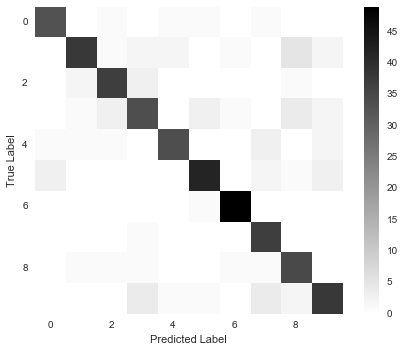

In [40]:
plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

### Exercise
1. Repeat this classification task with ``sklearn.ensemble.RandomForestClassifier``.  How does the ``max_depth``, ``max_features``, and ``n_estimators`` affect the results?
2. Try this classification with ``sklearn.svm.SVC``, adjusting ``kernel``, ``C``, and ``gamma``. Which classifier performs optimally?
3. Try a few sets of parameters for each model and check the F1 score (``sklearn.metrics.f1_score``) on your results. What's the best F1 score you can reach?

Accuracy: 0.98


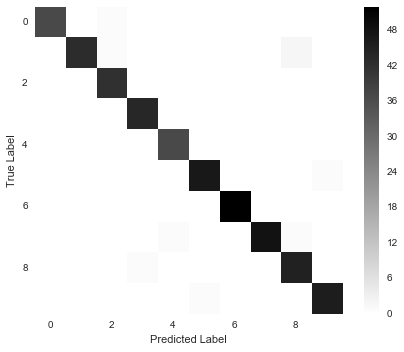

In [50]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = RandomForestClassifier(n_estimators=100, max_depth=50)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

print("Accuracy:", metrics.accuracy_score(ypred, ytest))

plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

Accuracy: 0.971111111111


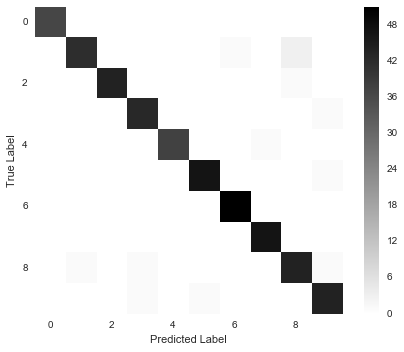

In [56]:
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = SVC(kernel='linear')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

print("Accuracy:", metrics.accuracy_score(ypred, ytest))

plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

F1 Score: 0.971098475863


/Users/Dongjun/.virtualenvs/DataScience/lib/python3.5/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


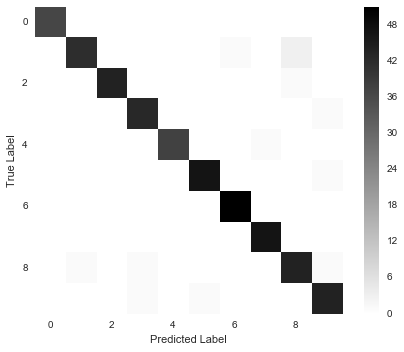

In [57]:
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = SVC(kernel='linear')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

print("F1 Score:", metrics.f1_score(ypred, ytest))

plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")